In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## Random sampling
- $0<t<100$, a hundred points in all
- $\tilde y=\sin(2\pi t)$, along with a Gaussian white noise (amplitude = 0.1)

In [67]:
from astropy.timeseries import LombScargle
import astropy.units as u

In [92]:
def amplitude(t, factor=2):
    if t % 4 < 1:
        return 1
    else:
        return factor * 1

In [93]:
best_freq = []
for factor in np.linspace(1, 10, 100):
    rand = np.random.RandomState()
    t = np.sort(100 * rand.rand(100)) #np.linspace(0, 5, 1000) # 
    y = [amplitude(item, factor=3) for item in t] * np.sin(2 * np.pi * t) + 0.1 * rand.rand(100)
    frequency, power = LombScargle(t, y).autopower()
    best_freq.append(frequency[np.argmax(power)])

Text(0,0.5,'best frequency')

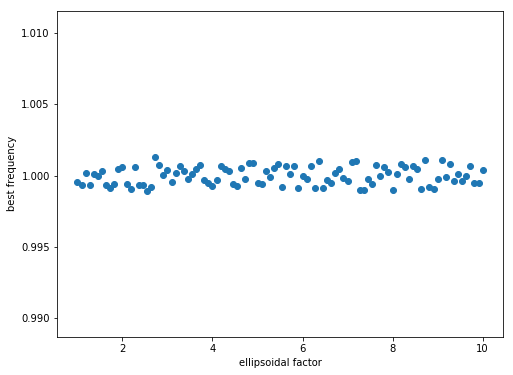

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(np.linspace(1, 10, 100), best_freq)
plt.xlabel('ellipsoidal factor')
plt.ylabel('best frequency')

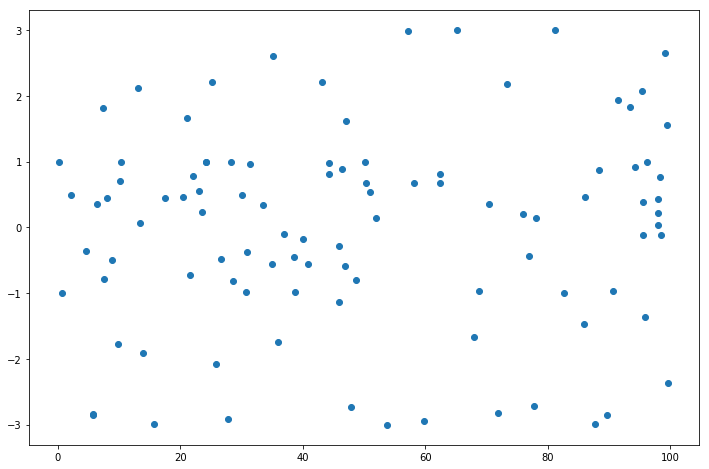

In [72]:
rand = np.random.RandomState()
t = np.sort(100 * rand.rand(100)) #np.linspace(0, 5, 1000) # 
y = [amplitude(item, factor=3) for item in t] * np.sin(2 * np.pi * t) #+ 0.1 * rand.rand(100)
plt.figure(figsize=(12, 8))
plt.scatter(t, y)

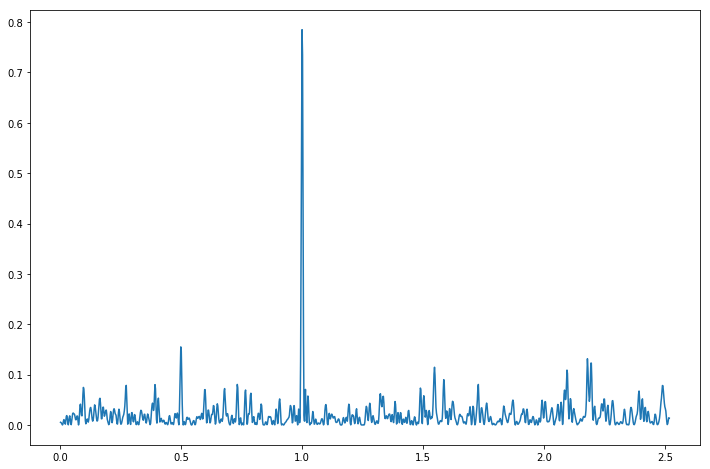

In [82]:
frequency, power = LombScargle(t, y).autopower()
plt.figure(figsize=(12,8))
plt.plot(frequency, power)

In [83]:
frequency[np.argmax(power)]

0.9992336775813092

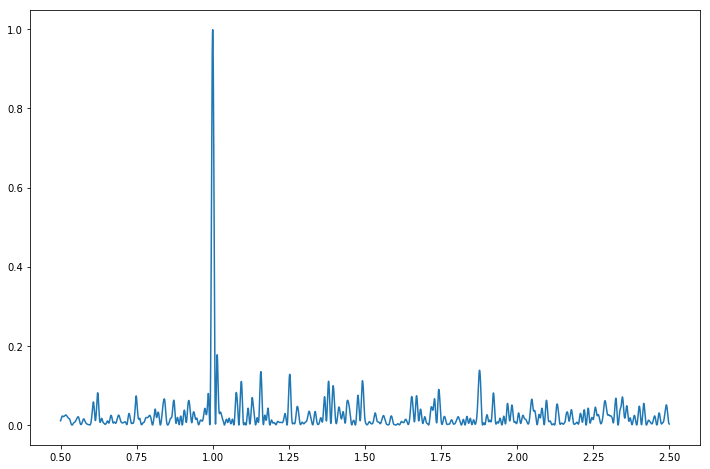

In [20]:
fre = np.linspace(0.5,2.5,10000)
power = LombScargle(t, y).power(fre)
plt.figure(figsize=(12,8))
plt.plot(fre, power)

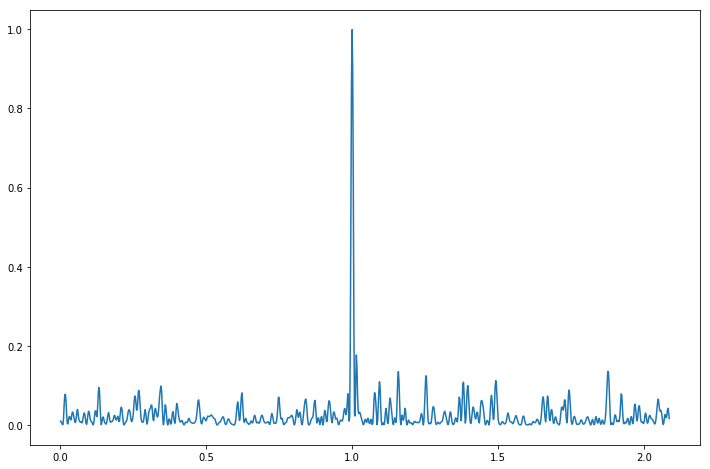

In [21]:
fre, power = LombScargle(t, y).autopower(nyquist_factor=4)
plt.figure(figsize=(12,8))
plt.plot(fre, power)

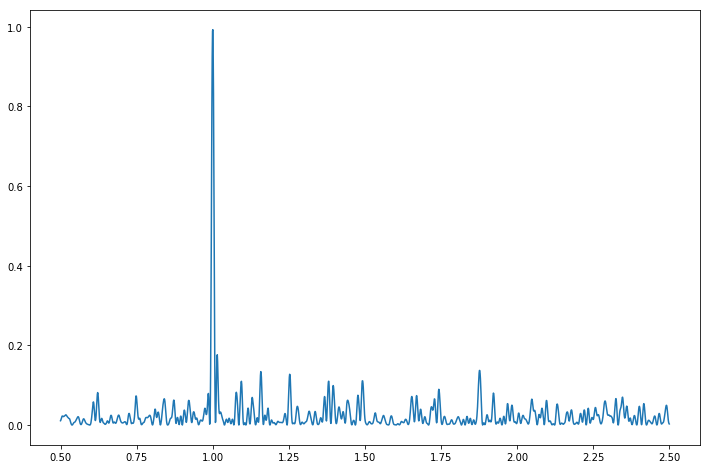

In [22]:
fre, power = LombScargle(t, y).autopower(
    minimum_frequency=0.5, maximum_frequency=2.5, samples_per_peak=10)
plt.figure(figsize=(12, 8))
plt.plot(fre, power)

- Consider uncertainty (error) in observation, $\sigma=0.2$

In [23]:
dy = np.random.randn(100)/5
LS = LombScargle(t, y,fit_mean=True)
fre, power = LS.autopower()
best_frequency = fre[power.argmax()]
best_frequency

0.9998810493219864

- Fit: $y = a + b\sin(2\pi \hat ft)+c\cos(2\pi \hat ft)$
- Draw the periodogram

0.9998810493219864

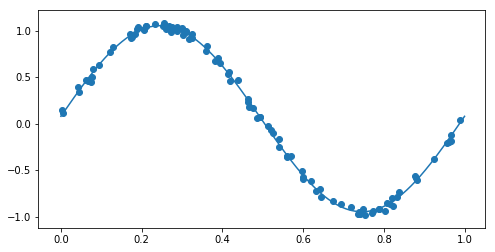

In [30]:
best_frequency = fre[np.argmax(power)]
t_fit = np.linspace(0, 1 / best_frequency, 1000)
y_fit = LS.model(t_fit, best_frequency)
plt.figure(figsize=(8, 4))
plt.plot(t_fit, y_fit)
a, b, c = LS.model_parameters(best_frequency)

plt.scatter((t) % (1 / best_frequency), y)
best_frequency

In [31]:
offset = LS.offset()
design_matrix = LS.design_matrix(best_frequency, t_fit)
#np.allclose(y_fit, offset + design_matrix.dot(theta))

<ErrorbarContainer object of 3 artists>

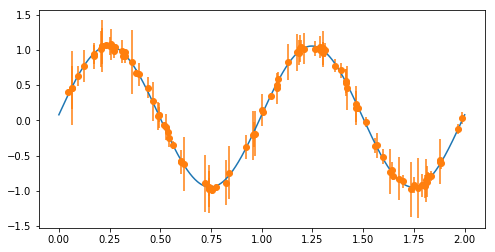

In [28]:
best_frequency = fre[np.argmax(power)]
t_fit = np.linspace(0, 1 / best_frequency * 2, 1000)
y_fit = LS.model(t_fit, best_frequency)
plt.figure(figsize=(8, 4))
plt.plot(t_fit, y_fit)
plt.errorbar((t) % (1 / best_frequency * 2), y, yerr=dy, fmt='o')

In [11]:
raw_g = np.loadtxt('ex_g')
raw_r = np.loadtxt('ex_r')
raw_i = np.loadtxt('ex_i')

In [12]:
def period(raw, col):
    raw = raw[raw[:,0].argsort()]
    raw[:,0] -= raw[0,0]
    LS = LombScargle(raw[:,0], raw[:,1], dy = raw[:,2], fit_mean=True)
    fre, power = LS.autopower(minimum_frequency=1e-10, maximum_frequency=50)
    best_frequency = fre[power.argmax()]
    
    plt.figure(figsize=(16,6), dpi=150)
    plt.subplot(121)
    plt.title('Power-frequency under LombScargle')
    plt.plot(fre, power, color=col)
    plt.xlabel('Frequency (Hz)', fontsize = 15)
    plt.ylabel('Power', fontsize = 15)
    
    plt.subplot(122)
    plt.title('Lightcurves')
    plt.errorbar(raw[:,0]%(1/best_frequency*2), raw[:,1], yerr = raw[:,2], color=col, fmt = 'o')
    plt.xlabel('Days', fontsize = 15)
    plt.ylabel('Magnitude', fontsize = 15)
    plt.gca().invert_yaxis()
    
    t_fit = np.linspace(0,1/best_frequency*2,1000)
    mag_fit = LS.model(t_fit,best_frequency)
    plt.plot(t_fit, mag_fit, color = 'black')
    
    print('Period: {:10.6f} Days'.format(1/best_frequency))
    print('Model parameters are: {}'.format(LS.model_parameters(best_frequency)))
    return(1/best_frequency)

### g band

- Model parameters $\theta_n$:
$$
   y(t ; f, \vec{\theta})=\theta_{0}+\sum_{n=1}^{\text { nterns }}\left[\theta_{2 n-1} \sin (2 \pi n f t)+\theta_{2 n} \cos (2 \pi n f t)\right]
$$

Period:   0.155596 Days
Model parameters are: [0.0089739  0.00913693 0.07261083]


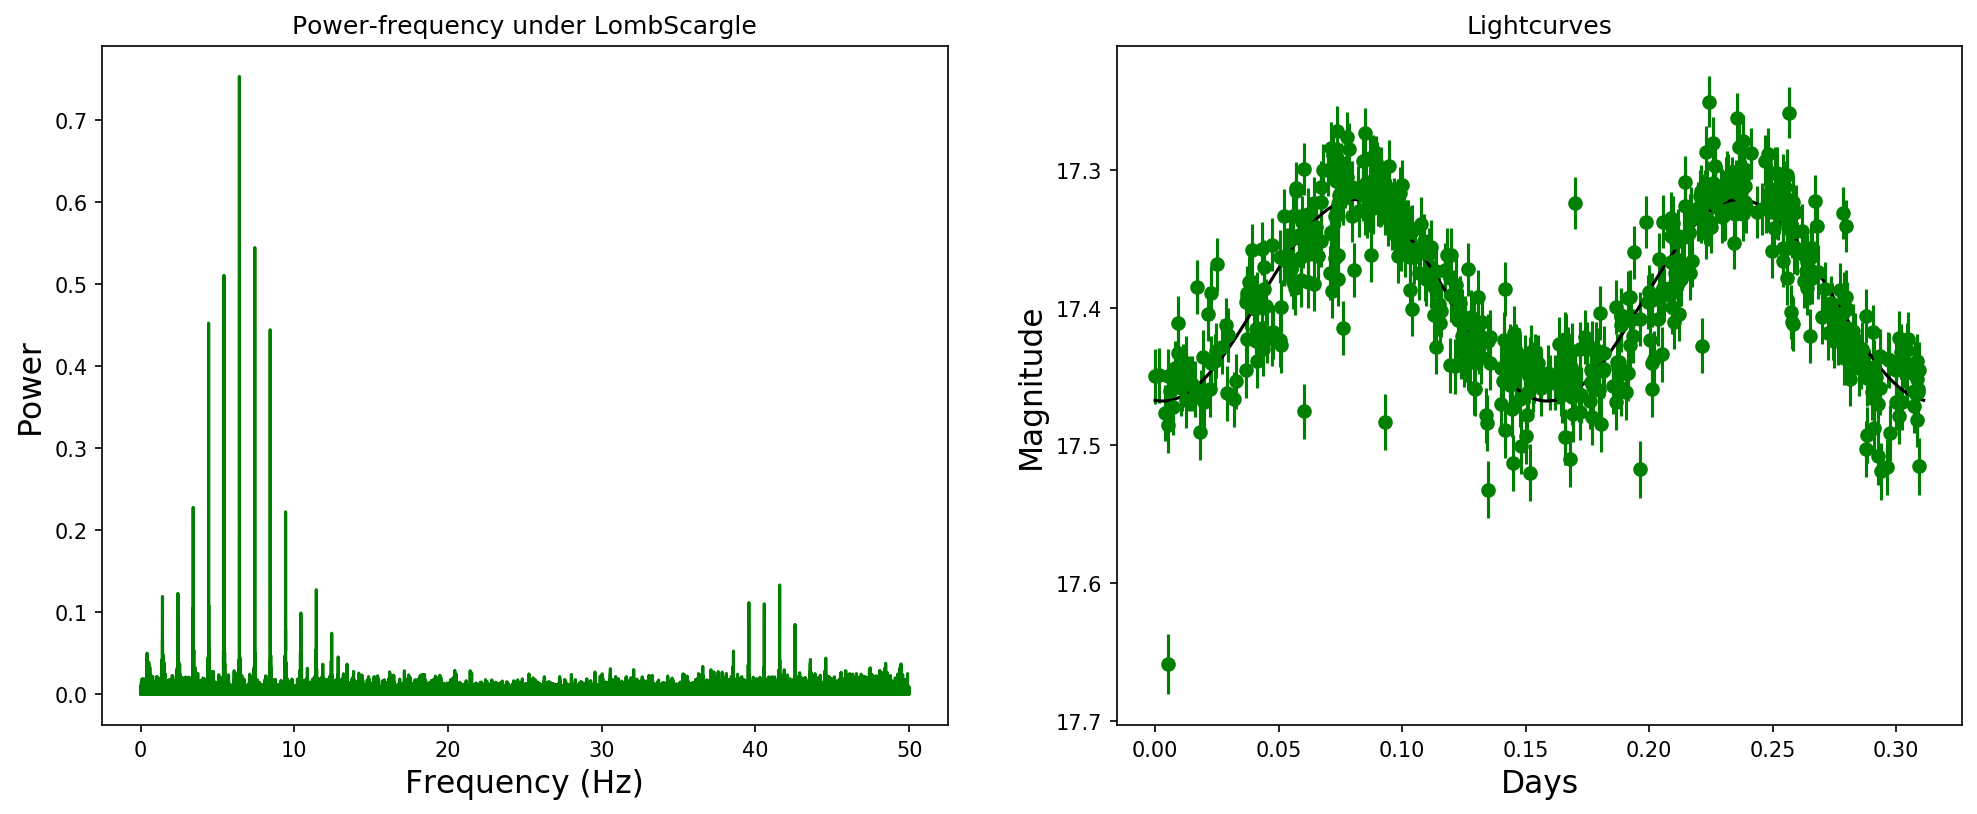

In [13]:
pg = period(raw_g,'green')

### r band

Period:   0.155590 Days
Model parameters are: [0.01712923 0.04817438 0.17392221]


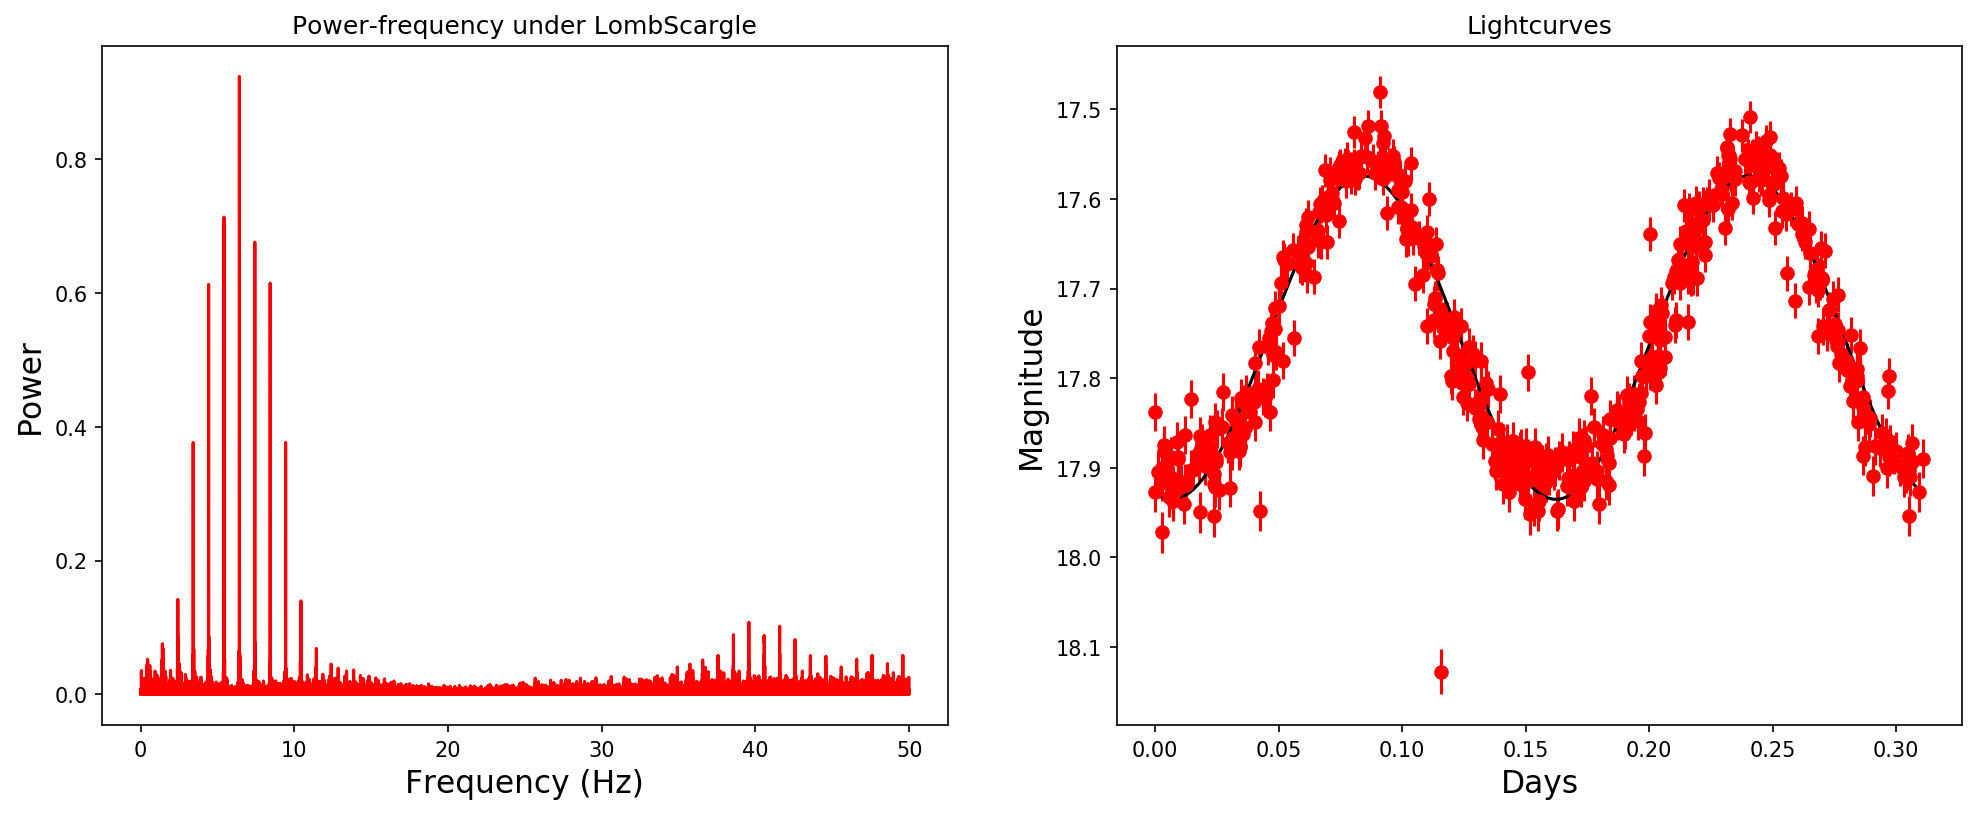

In [14]:
pr = period(raw_r,'red')

### i band

Period:   0.155589 Days
Model parameters are: [ 0.0515967  -0.17080086 -0.17848187]


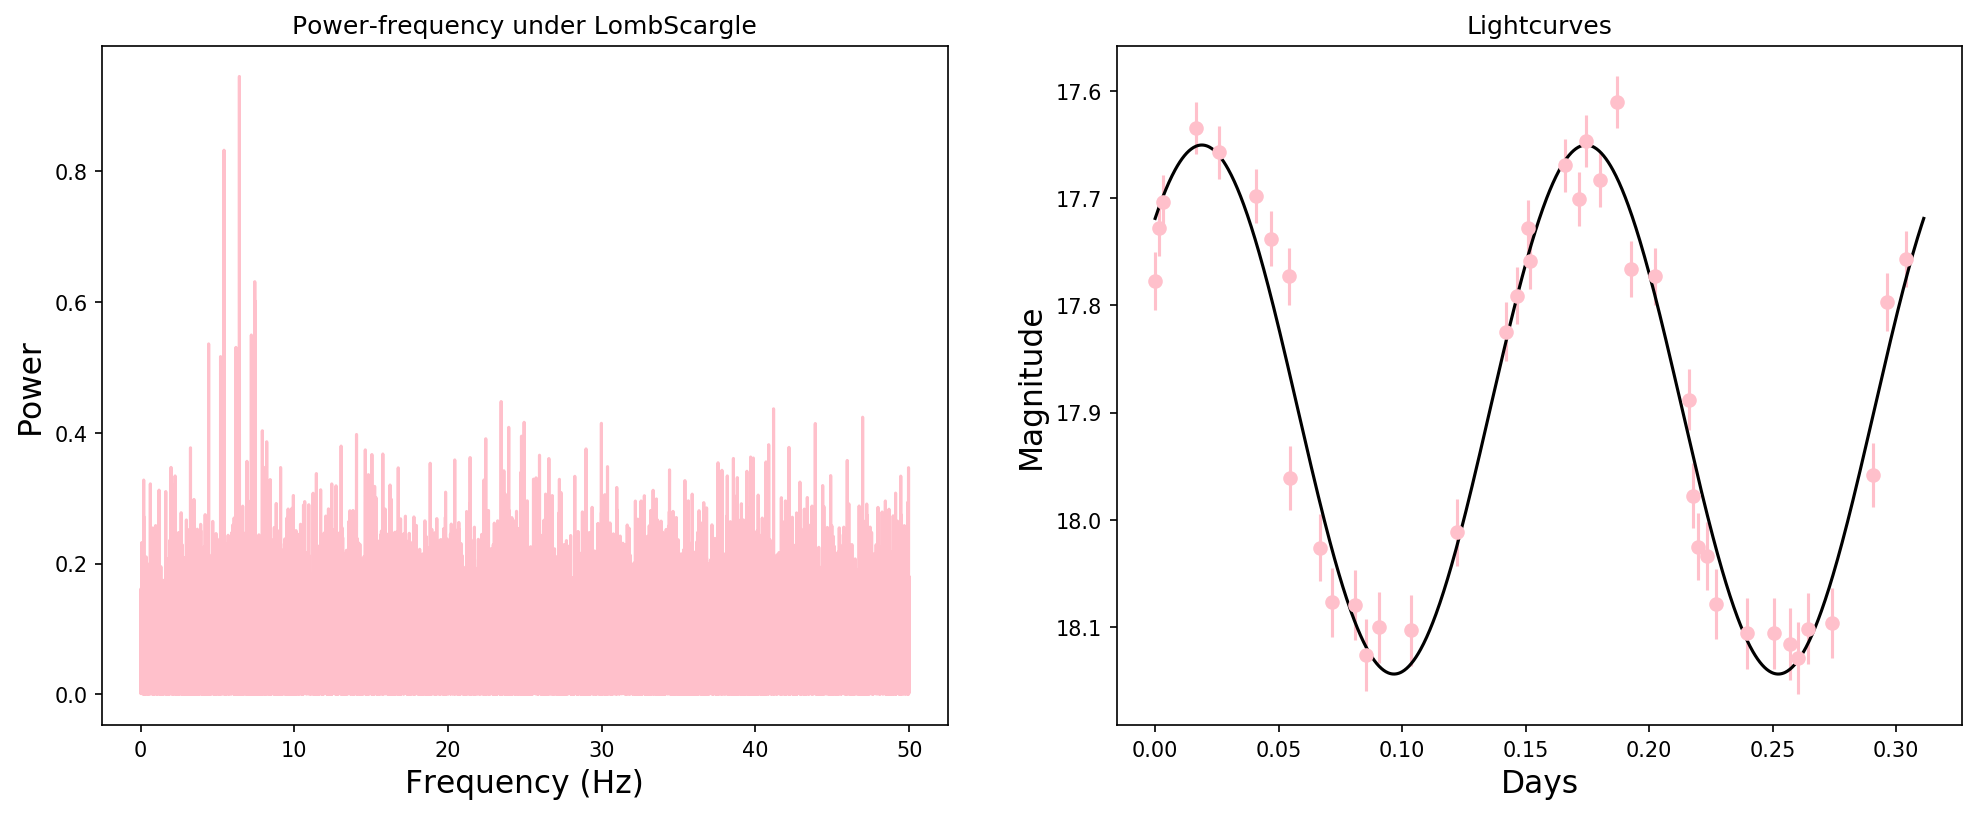

In [15]:
pi = period(raw_i,'pink')

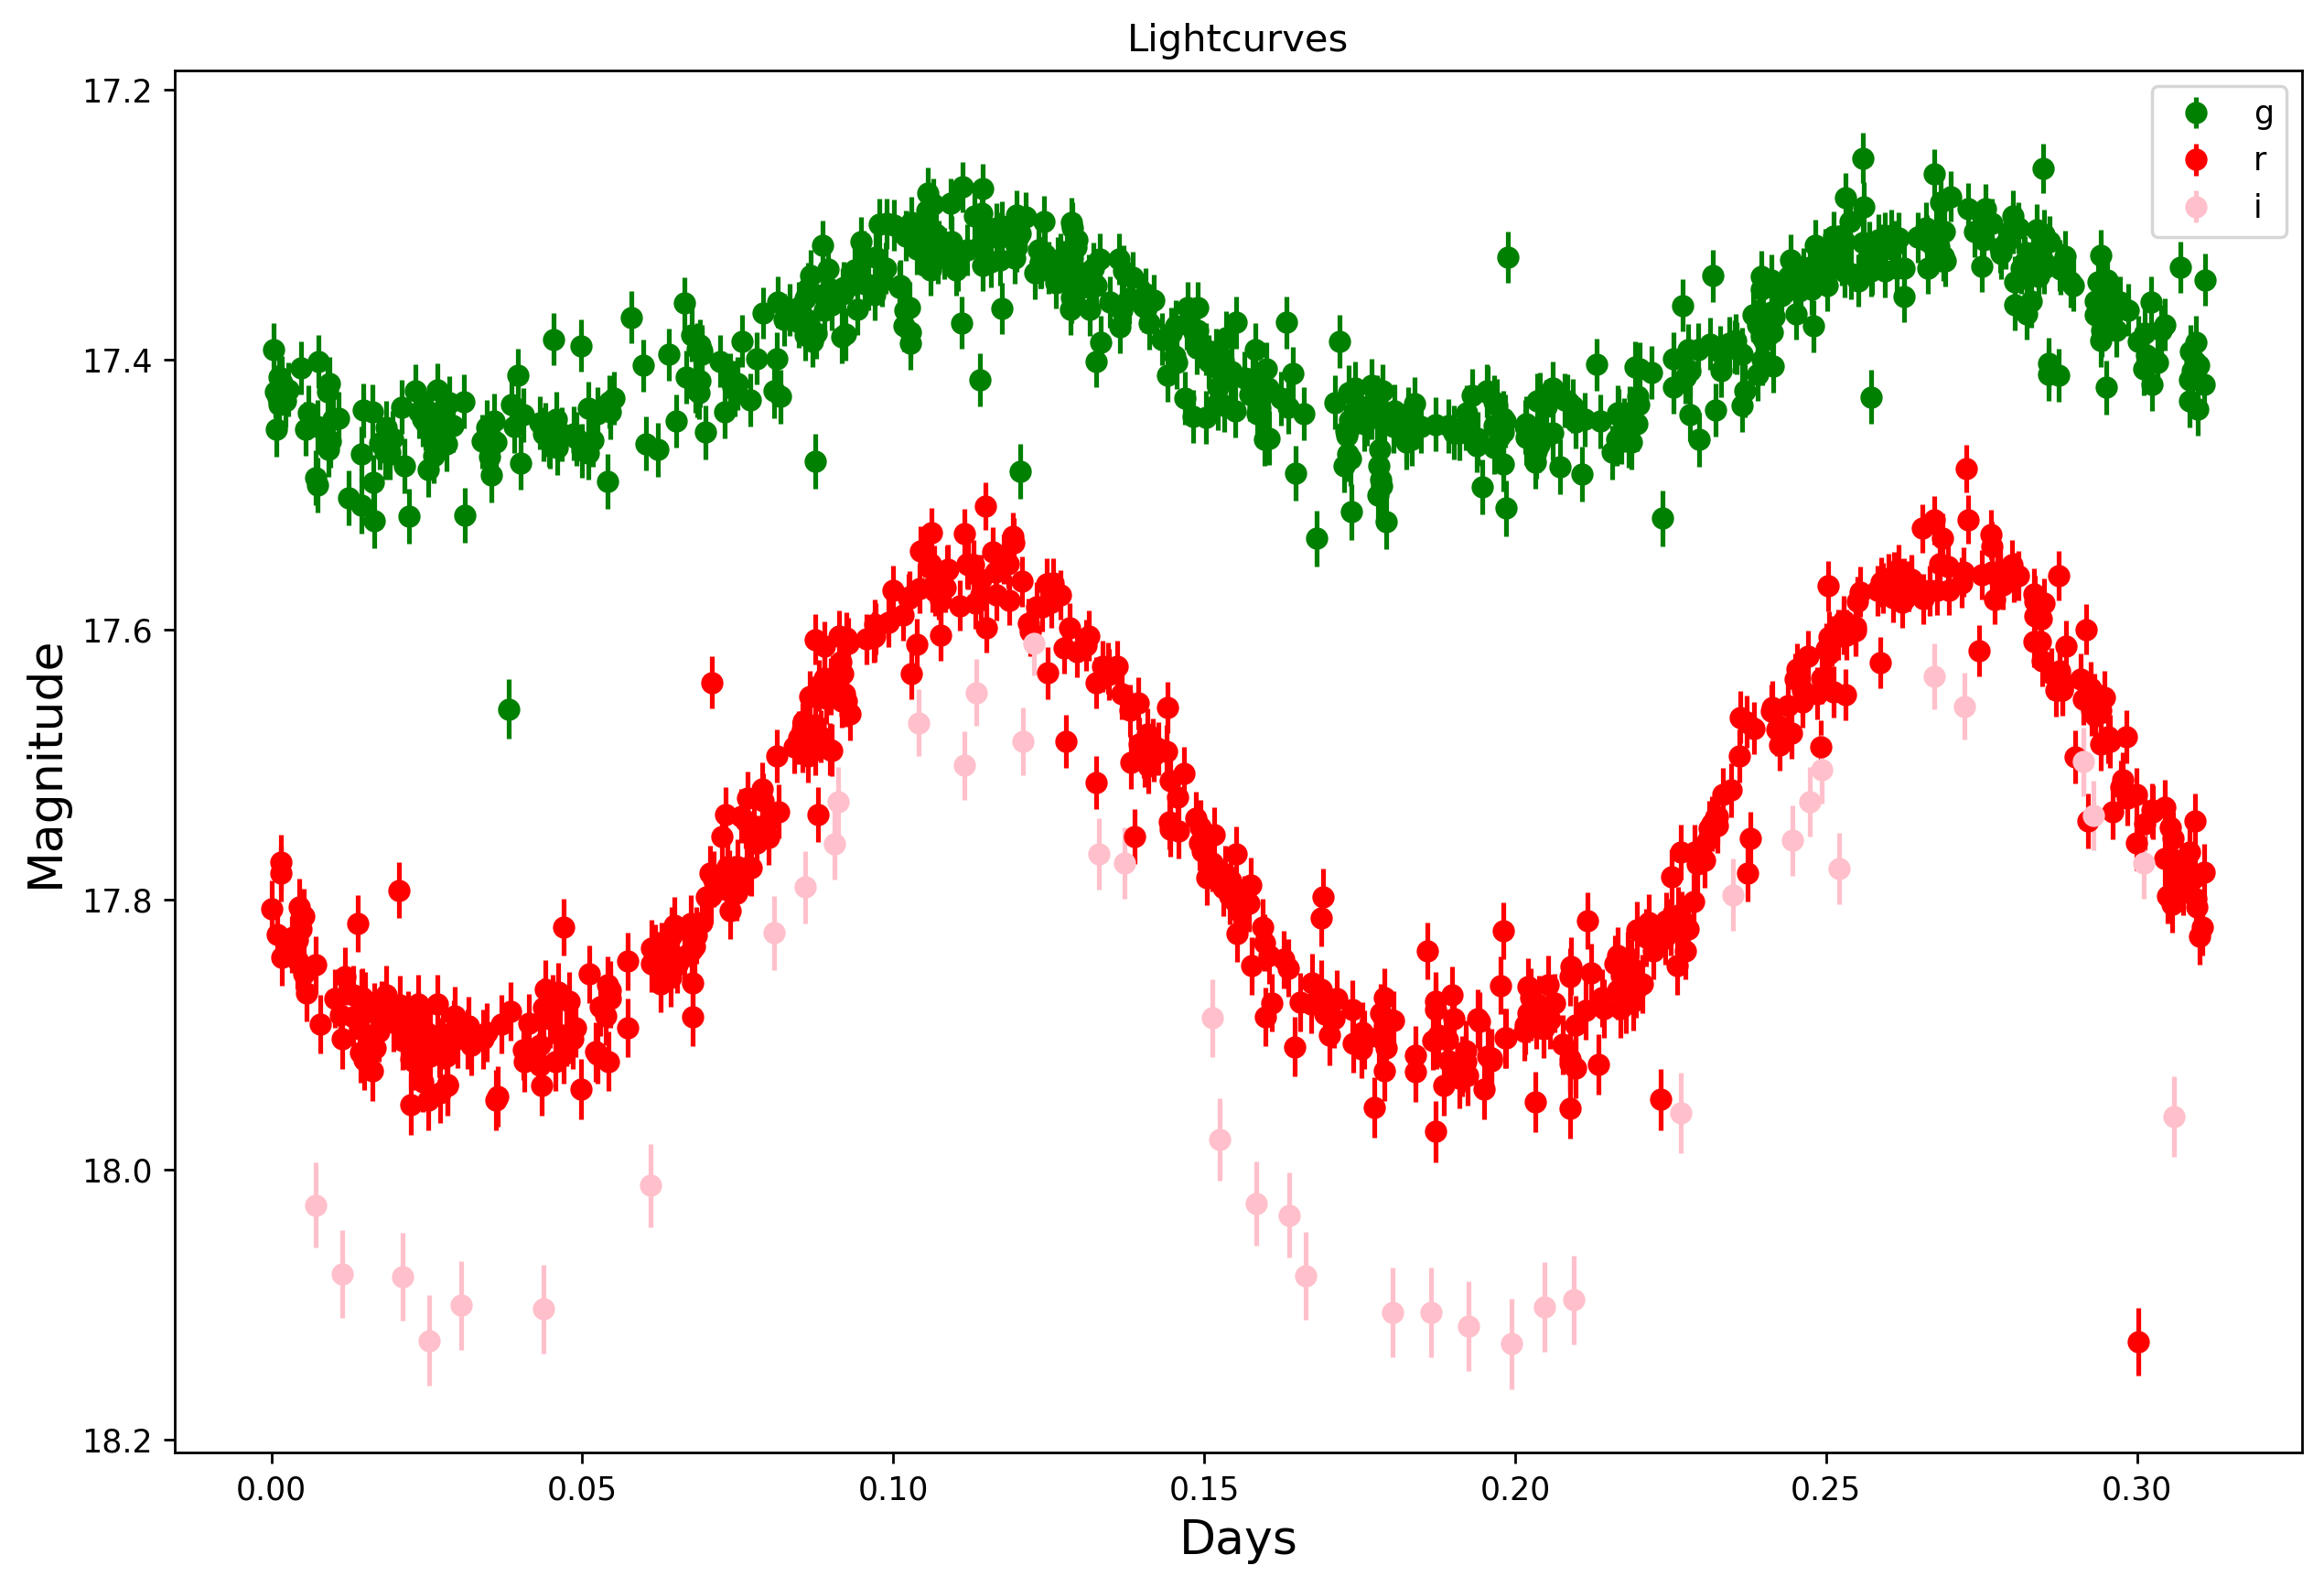

In [16]:
P = (pg+pr+pi)/3
zero_point = min(raw_g[0,0], raw_r[0,0], raw_i[0,0])
plt.figure(figsize=(12,8), dpi=250)
plt.title('Lightcurves')
plt.errorbar((raw_g[:,0]-zero_point)%(P*2), raw_g[:,1], yerr = raw_g[:,2], color='green', fmt = 'o', label = 'g')
plt.errorbar((raw_r[:,0]-zero_point)%(P*2), raw_r[:,1], yerr = raw_r[:,2], color='red', fmt = 'o', label = 'r')
plt.errorbar((raw_i[:,0]-zero_point)%(P*2), raw_i[:,1], yerr = raw_i[:,2], color='pink', fmt = 'o', label = 'i')
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Magnitude', fontsize = 15)
plt.gca().invert_yaxis()
plt.legend()

where the zero point of time is JD 2458357.6932345442, on Aug. 27, 2018